# Deep Learning with PyTorch : Build a Generative Adversarial Network 

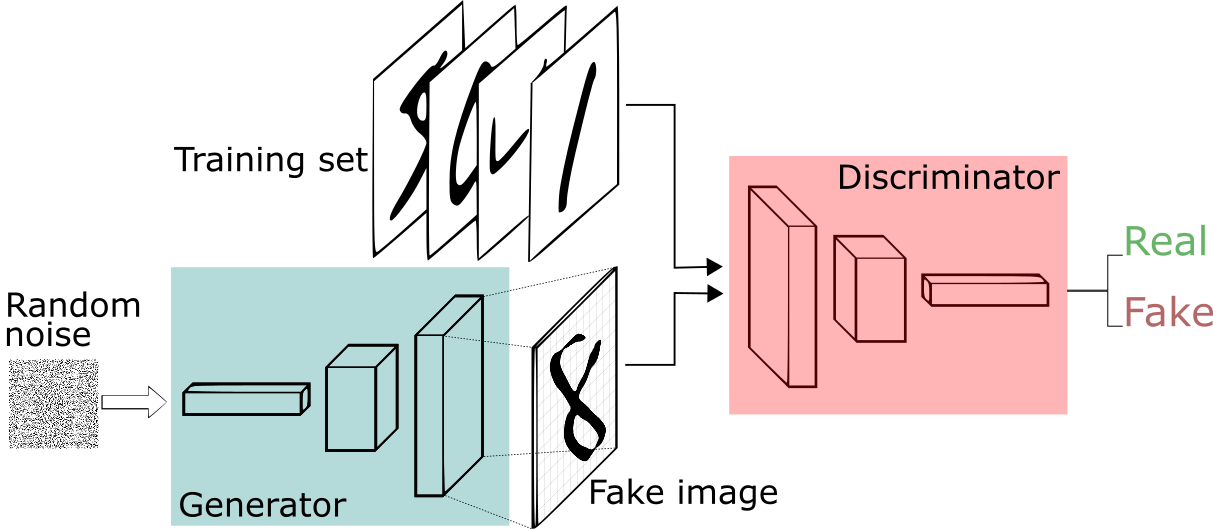

In [1]:
import torch
from torch.xpu import device

torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm import tqdm

# Configurations

In [2]:
device = "cpu"

batch_size = 128

noise_dim = 64

# Optimizers parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([T.RandomRotation((-20, 20)),
                        T.ToTensor() # (h, w, c) -> (c, h, w)
                        ])

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

trainset = datasets.MNIST('MINST/', train=True, transform=train_augs, download=True)

Total images:  60000


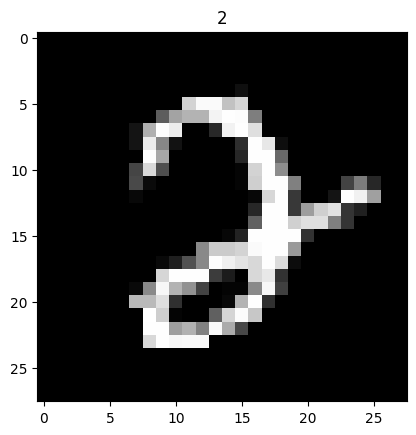

In [6]:
image, label = trainset[16]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

print("Total images: ", len(trainset))

# Load Dataset Into Batches 

In [7]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [8]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [9]:
print("Total number of batches: ", len(trainloader))

Total number of batches:  469


In [10]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [11]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

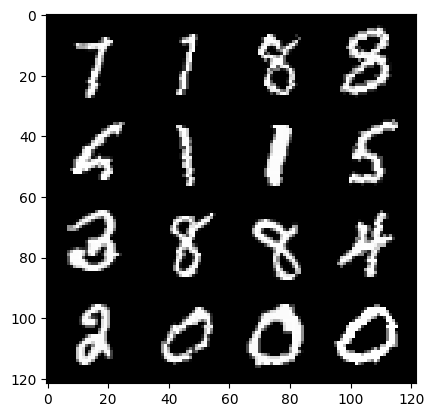

In [12]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network 

In [13]:
#In case if torch summary is not installed 

!pip install torchsummary


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
from torch import nn
from torchsummary import summary

In [15]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [16]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = get_disc_block(in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)
        self.block2 = get_disc_block(in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)
        self.block3 = get_disc_block(in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)
        
    def forward(self, images):
        images = images.to(device)
        x1 = self.block1(images)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        
        return x5
    
    

In [18]:
D = Discriminator()
D.to(device)
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [19]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [20]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride),
            nn.Tanh(),
        )
    
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        )

In [21]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        
        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)
        
    def forward(self, rnd_noise_vec):
        # (bs, noise_dim) -> (bs, noise_dime, 1, 1)
        x = rnd_noise_vec.view(-1, self.noise_dim, 1, 1)
        
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        
        return x4

In [22]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [23]:
# Replace Random initialized weights to Normal weights (for robust training)

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [24]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [25]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [26]:
def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [27]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas = (beta_1, beta_2))

# Training Loop 

100%|██████████| 469/469 [01:35<00:00,  4.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98085576..0.9932776].


Epoch: 1 | D loss: 0.6830900225049651 | G loss: 0.6928541496364292


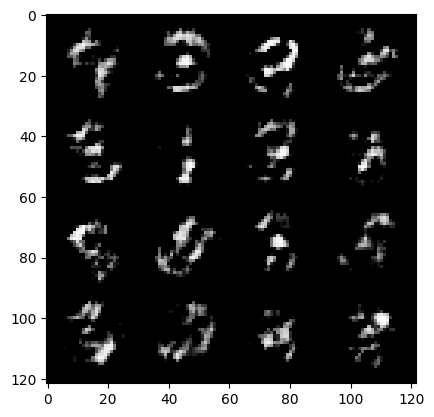

100%|██████████| 469/469 [01:35<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98157734..0.9972241].


Epoch: 2 | D loss: 0.6747365931966411 | G loss: 0.7143715401448166


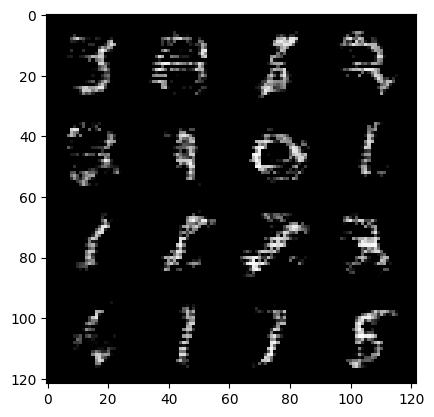

100%|██████████| 469/469 [01:34<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7650063..0.99999815].


Epoch: 3 | D loss: 0.642460248236463 | G loss: 0.748910202781783


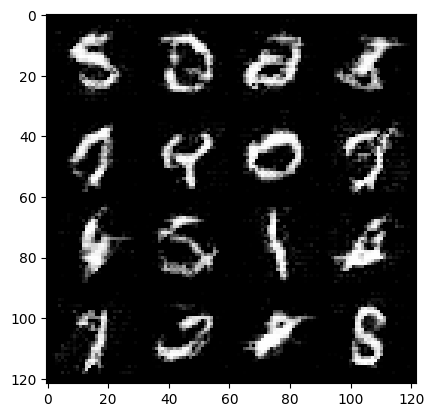

100%|██████████| 469/469 [01:34<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53322905..0.99999493].


Epoch: 4 | D loss: 0.6277484916674811 | G loss: 0.7698089315184652


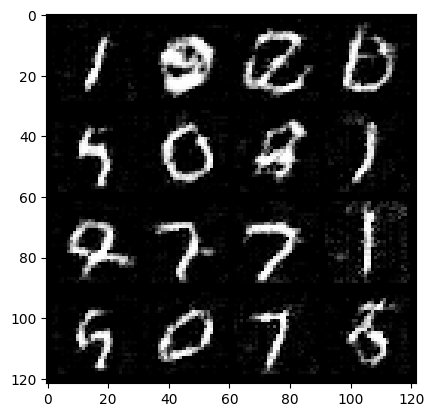

100%|██████████| 469/469 [01:33<00:00,  4.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44945636..1.0].


Epoch: 5 | D loss: 0.6245741631938959 | G loss: 0.7800905205039327


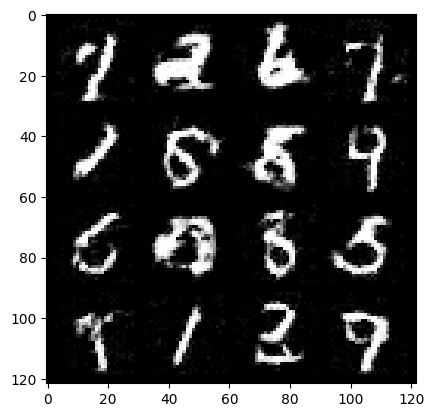

100%|██████████| 469/469 [01:34<00:00,  4.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.595034..1.0].


Epoch: 6 | D loss: 0.6298828904054312 | G loss: 0.7834493718675967


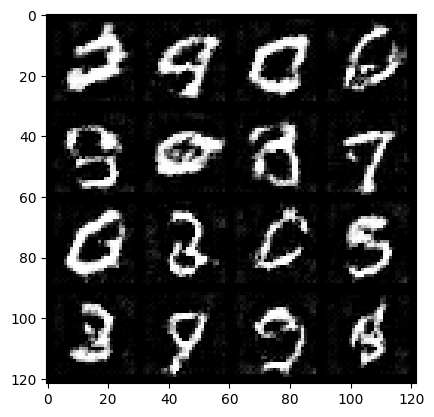

100%|██████████| 469/469 [01:34<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48343375..1.0].


Epoch: 7 | D loss: 0.635615450995309 | G loss: 0.7824707931038667


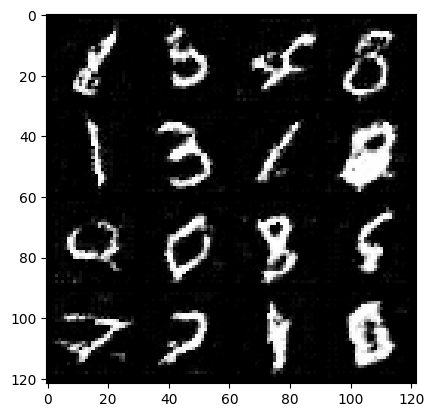

100%|██████████| 469/469 [01:31<00:00,  5.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38860565..1.0].


Epoch: 8 | D loss: 0.6378021204649512 | G loss: 0.7892156793618761


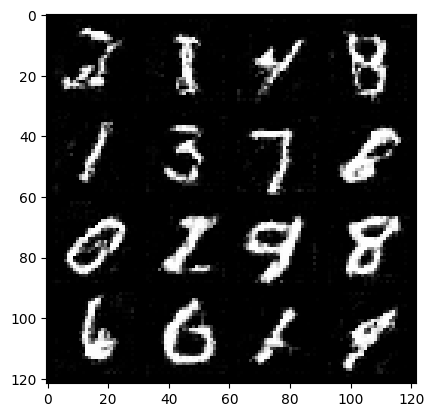

100%|██████████| 469/469 [01:31<00:00,  5.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2613665..1.0].


Epoch: 9 | D loss: 0.6421065852840318 | G loss: 0.787464809061876


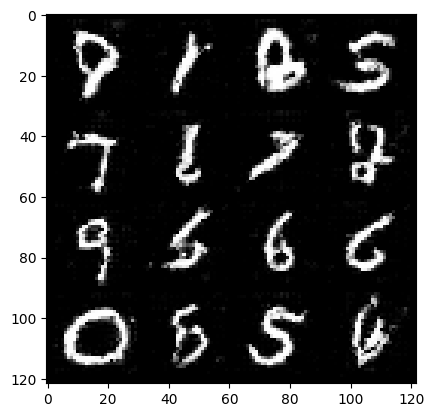

100%|██████████| 469/469 [01:35<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40569082..1.0].


Epoch: 10 | D loss: 0.6455442201354102 | G loss: 0.782650717031727


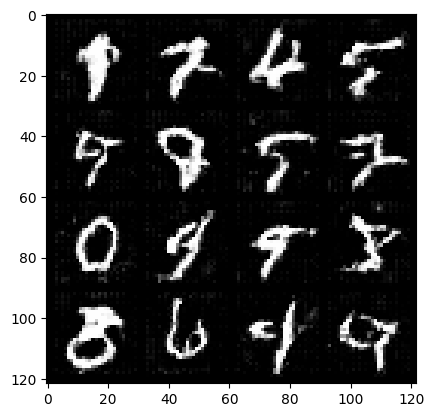

100%|██████████| 469/469 [01:39<00:00,  4.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24119024..1.0].


Epoch: 11 | D loss: 0.6498440298190249 | G loss: 0.7800111122477029


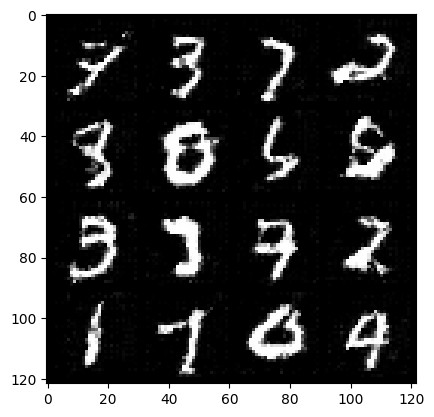

100%|██████████| 469/469 [01:39<00:00,  4.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26080582..1.0].


Epoch: 12 | D loss: 0.6534272911452027 | G loss: 0.7796824437214621


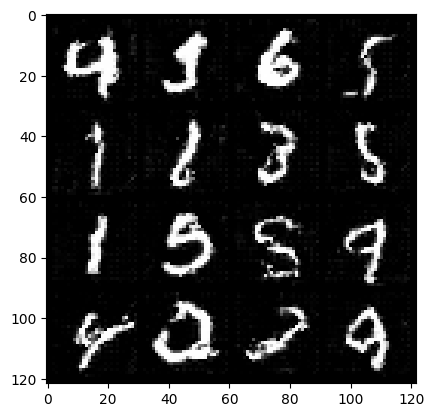

100%|██████████| 469/469 [01:51<00:00,  4.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27346152..1.0].


Epoch: 13 | D loss: 0.655203833127581 | G loss: 0.7782065344771851


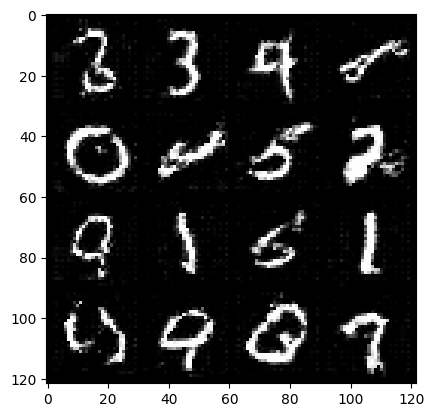

100%|██████████| 469/469 [01:37<00:00,  4.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30668184..1.0].


Epoch: 14 | D loss: 0.6554865196569643 | G loss: 0.7779622954854579


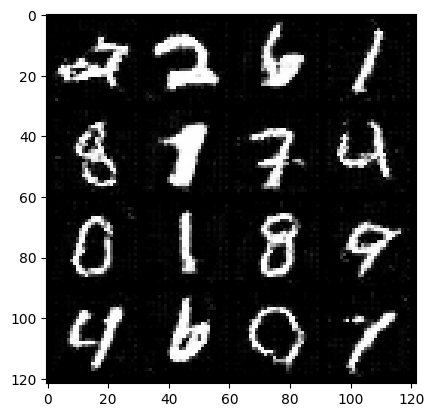

100%|██████████| 469/469 [01:35<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26836404..1.0].


Epoch: 15 | D loss: 0.6564736859376497 | G loss: 0.7772402133006276


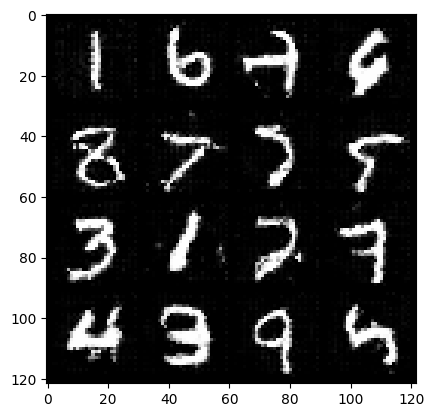

100%|██████████| 469/469 [01:35<00:00,  4.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3248812..1.0].


Epoch: 16 | D loss: 0.6570042428939835 | G loss: 0.7756809767629547


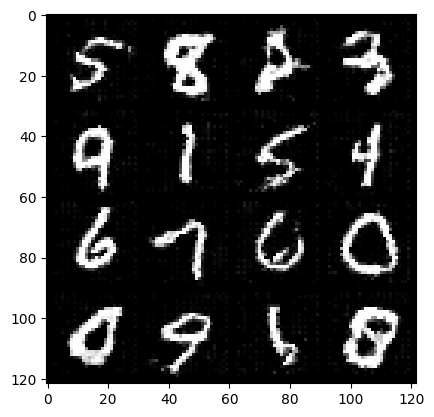

100%|██████████| 469/469 [01:32<00:00,  5.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38544387..1.0].


Epoch: 17 | D loss: 0.6575596106331995 | G loss: 0.7746400606911829


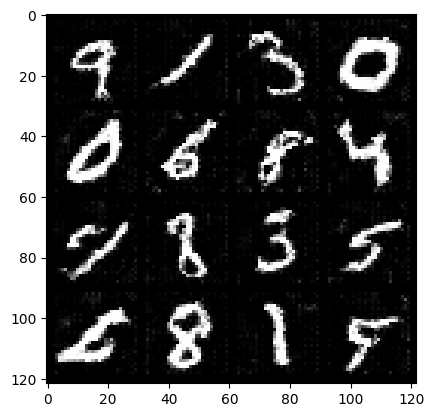

100%|██████████| 469/469 [01:31<00:00,  5.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27943644..1.0].


Epoch: 18 | D loss: 0.6591853953119534 | G loss: 0.7735816209809359


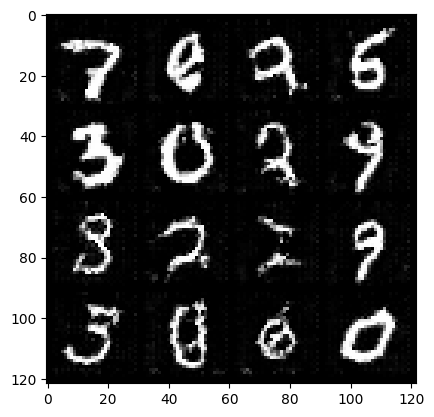

100%|██████████| 469/469 [01:33<00:00,  4.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5890134..1.0].


Epoch: 19 | D loss: 0.6599720097554009 | G loss: 0.7750170659154717


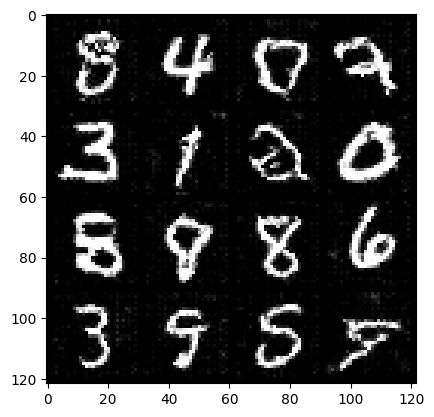

100%|██████████| 469/469 [01:41<00:00,  4.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29887405..1.0].


Epoch: 20 | D loss: 0.6599126341246339 | G loss: 0.7734330033442613


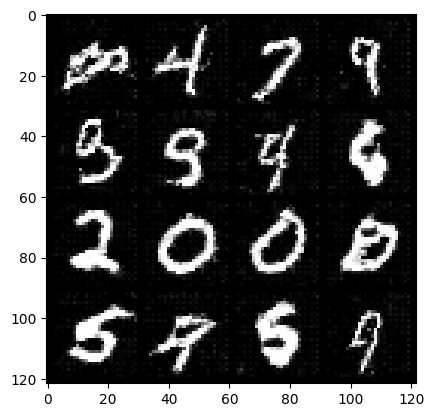

In [28]:

for i in range(epochs):
    total_d_loss = 0
    total_g_loss = 0
    
    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)
        
        # find loss and update weights for D
        D_opt.zero_grad()
        
        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)
        
        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        
        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()
        
        D_loss.backward()
        D_opt.step()
        
        # find loss and update weights for G
        G_opt.zero_grad()
        
        noise = torch.randn(batch_size, noise_dim, device=device)
        
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        total_g_loss += G_loss.item()
        
        G_loss.backward()
        G_opt.step()
        
    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)
    
    print("Epoch: {} | D loss: {} | G loss: {}".format(i+1, avg_d_loss, avg_g_loss))
    
    show_tensor_images(fake_img)
        
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21925128..1.0].


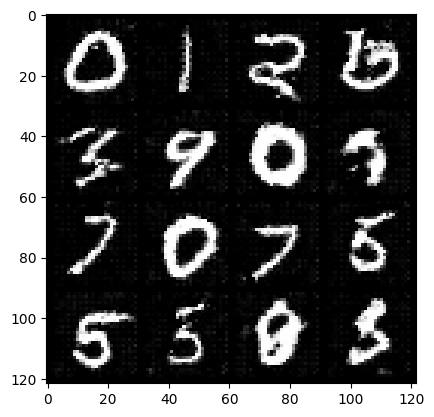

In [33]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya